In [26]:
import math
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import random
from torch.autograd import Variable
from matplotlib import pyplot as plt
import seaborn as sns
from torch import nn
from collections import OrderedDict

import torchmetrics

import optuna

from tqdm import tqdm

import time
# import plotly.graph_objects as go
import os

In [27]:
torch.set_default_dtype(torch.float64)

# Rede

In [28]:
class DGM():
  def __init__(self, n_neurons, activation_function):
    self._n_neuros = n_neurons
    self.u_g = torch.randn((2, n_neurons), requires_grad=True)
    self.u_z = torch.randn((2, n_neurons), requires_grad=True)
    self.u_r = torch.randn((2, n_neurons), requires_grad=True)
    self.u_h = torch.randn((2, n_neurons), requires_grad=True)

    self.w_z = torch.randn((n_neurons, n_neurons), requires_grad=True)
    self.w_g = torch.randn((n_neurons, n_neurons), requires_grad=True)
    self.w_r = torch.randn((n_neurons, n_neurons), requires_grad=True)
    self.w_h = torch.randn((n_neurons, n_neurons), requires_grad=True)

    self.b_z = torch.randn((1, n_neurons), requires_grad=True)
    self.b_g = torch.randn((1, n_neurons), requires_grad=True)
    self.b_r = torch.randn((1, n_neurons), requires_grad=True)
    self.b_h = torch.randn((1, n_neurons), requires_grad=True)

    self.activation_function = activation_function()

  def forward(self, s, x):  # sourcery skip: inline-immediately-returned-variable
    tt = torch.matmul(x, self.u_z) + torch.matmul(s, self.w_z,) + self.b_z
    z = self.activation_function(torch.matmul(x, self.u_z) + torch.matmul(s, self.w_z,) + self.b_z)
    g = self.activation_function(torch.matmul(x, self.u_g) + torch.matmul(s, self.w_g,) + self.b_g)
    r = self.activation_function(torch.matmul(x, self.u_r) + torch.matmul(s, self.w_r,) + self.b_r)
    h = self.activation_function(torch.matmul(x, self.u_h) + torch.matmul(s*r, self.w_h) + self.b_h)

    s_novo = (1-g)*h + z*s
    return s_novo


In [29]:
class Model(nn.Module):
    def __init__(self, n_input, n_neurons, activation_function):
        super(Model, self).__init__()

        self._n_input = n_input
        self._n_neuros = n_neurons

        self.features = nn.Sequential(
            nn.Linear(n_input, n_neurons),
            #getattr(nn, activation_functions[0])()
            activation_function()
        )


        self.d_1 = DGM(n_neurons, activation_function)
        self.d_2 = DGM(n_neurons, activation_function)
        self.d_3 = DGM(n_neurons, activation_function)


        self.out = nn.Sequential(
            nn.Linear(n_neurons, 1),
            # nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # sourcery skip: inline-immediately-returned-variable
        s = self.features(x)
        s = self.d_1.forward(s, x)
        s = self.d_2.forward(s, x)
        s = self.d_3.forward(s, x)
        output = self.out(s)

        return output


In [30]:
class Net():
    def __init__(self, n_input, n_neurons, activation_functions, loss, loss_params: dict, optimizer, optimizer_params: dict):
        self.activation_function = activation_functions
        self.loss = loss
        self.loss_params = loss_params
        self.network = Model(n_input, n_neurons, activation_functions)
        self.optimizer = optimizer(
            self.network.parameters(), **optimizer_params)

    def net(self):
      return self.network

    def fit(self, x, epochs=1000, nbatches=1, output_loss=True):
        epochs_array = []
        loss_array = []
        index = torch.randperm(x.shape[0])

        batchs = torch.split(index, int(len(index)/nbatches))

        for epoch in range(1, epochs+1):
            for batch in batchs:
                self.optimizer.zero_grad()

                loss = self.loss(inp=x[batch], model=self.network, **self.loss_params)
                sum(loss).backward()
                self.optimizer.step()

            if epoch % 1000 == 0:
                if output_loss:
                    print(f'Epoch {epoch}, Loss {float(sum(loss))}')
                epochs_array.append(epoch)
                loss_array.append([i.detach().numpy() for i in loss])

        return epochs_array, loss_array

    @torch.no_grad()  # Desabilita o calculo do gradiente
    def predict(self, x: torch.Tensor):
        return self.network.forward(x)


In [31]:
def metricas(net, sol_eq, a, b):
    """Calcula a o erro médio quadrado e o erro médio
    absoluto de uma rede neural.

    Parameters
    ----------
    net : _type_
        Rede neural
    sol_eq : _type_
        Função da equação analítica
    a : int
        _description_
    b : int
        _description_

    Returns
    -------
    Tuple
        Erro médio quadrado e erro médio absoluto
    """
    xx = torch.linspace(0, a, 100)
    yy = torch.linspace(0, b, 100)

    xx, yy = torch.meshgrid(xx, yy, indexing='xy')

    xx = xx.reshape((xx.shape[0]**2, 1))
    yy = yy.reshape((yy.shape[0]**2, 1))

    sol = sol_eq(xx, yy)
    prev = net.predict(torch.cat([xx, yy], axis=1))

    return torchmetrics.functional.mean_squared_error(sol, prev),\
           torchmetrics.functional.mean_absolute_error(sol, prev)

In [32]:
def plot_solucao_erro_l2(net, sol_eq, a, b):
    xx = torch.linspace(0, a, 100)
    yy = torch.linspace(0, b, 100)

    xx, yy = torch.meshgrid(xx, yy, indexing='xy')

    xx = xx.reshape((xx.shape[0]**2, 1))
    yy = yy.reshape((yy.shape[0]**2, 1))

    sol = sol_eq(xx, yy)
    prev = net.predict(torch.cat([xx, yy], axis=1))

    prev = prev.reshape((100, 100))
    sol = sol.reshape((100, 100))
    xx = xx.reshape((100, 100))
    yy = yy.reshape((100, 100))

    #plot
    fig1, ax = plt.subplots(1, 2, figsize=(20,7))

    img1 = ax[0].pcolor(xx.numpy(), yy.numpy(), sol.numpy(), vmin=0, vmax=1)
    fig1.colorbar(img1, ax=ax[0])
    ax[0].set_title('Solução Analítica')
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')

    img2 = ax[1].pcolor(xx.numpy(), yy.numpy(), prev.numpy(), vmin=0, vmax=1)
    fig1.colorbar(img2, ax=ax[1])

    ax[1].set_title('Solução numérica obtida pela rede neural1')
    ax[1].set_xlabel('x')
    ax[1].set_ylabel('y')
    #plt.show()

    # Plot erro L2
    fig, ax = plt.subplots(1, 1, figsize=(7,5))

    img1 = ax.pcolor(xx.numpy(), yy.numpy(), abs(prev.numpy() - sol.numpy()), vmin=0, vmax=0.1)
    fig.colorbar(img1, ax=ax)
    ax.set_title('Erro L2')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    #plt.show()

    return fig1, fig


# Derivadas

In [33]:
def dy(model, x, y, h=0.001):
    # d = torch.autograd.grad(model(x, t), (x, t), grad_outputs=torch.ones_like(
    #    model(x, t)), create_graph=True, retain_graph=True)
    # return d[1]
    inp = torch.cat([x.unsqueeze(0), y.unsqueeze(0)]).T
    y = y+h
    inp_h = torch.cat([x.unsqueeze(0), y.unsqueeze(0)]).T
    return (model.forward(inp_h[0]) - model.forward(inp[0]))/h


def dyy(model, x, y, h=0.001):
    y_plus_h = torch.cat([x.unsqueeze(0), (y + h).unsqueeze(0)]).T
    y_minus_h = torch.cat([x.unsqueeze(0), (y - h).unsqueeze(0)]).T
    inp = torch.cat([x.unsqueeze(0), y.unsqueeze(0)]).T

    return (model.forward(y_plus_h[0]) - 2*model.forward(inp[0]) + model.forward(y_minus_h[0]))/h**2


def dx(model, x, y, h=0.001):
    inp = torch.cat([x.unsqueeze(0), y.unsqueeze(0)]).T
    x = x+h
    inp_h = torch.cat([x.unsqueeze(0), y.unsqueeze(0)]).T

    return (model.forward(inp_h[0]) - model.forward(inp[0]))/h


def dxx(model, x, y, h=0.001):
    x_plus_h = x + h
    x_1 = torch.cat([x_plus_h.unsqueeze(0), y.unsqueeze(0)]).T
    x_minus_h = x - h
    x_3 = torch.cat([x_minus_h.unsqueeze(0), y.unsqueeze(0)]).T
    x_2 = torch.cat([x.unsqueeze(0), y.unsqueeze(0)]).T

    return (model.forward(x_1[0]) - 2*model.forward(x_2[0]) + model.forward(x_3[0]))/h**2


# Gráficos

In [34]:
def plot_convergencia(epochs_array, loss_array):
  loss = np.array(loss_array).sum(axis=1)

  fig = plt.figure(figsize=(10, 5))
  ax = sns.lineplot(x=epochs_array, y=loss)
  # Configurar os labels do eixo x e y
  plt.xlabel('Épocas')
  plt.ylabel('Loss')
  plt.title('Gráfico de Convergência')

  return fig

# Loss

In [35]:
def k(y):
  if 0<= y and y<= 1:
    return y
  elif 1<= y and y<=2:
    return 2-y

def k_derivado(y):
  if 0<= y and y<= 1:
    return 1
  elif 1<= y and y<=2:
    return -1

In [36]:
def loss_laplace(model, inp: torch.tensor, aceleracao):
    taxa_de_aceleracao = 0.001**2 if aceleracao else 1
    x = inp[:, 0].unsqueeze(0).T
    y = inp[:, 1].unsqueeze(0).T
    # Perda domínio
    loss_dom = (dxx(model, x, y) + dyy(model, x, y))**2
    L1 = loss_dom.sum()*taxa_de_aceleracao


    # Perda contorno y
    zero = torch.zeros(y.size()[0], 1, requires_grad=True)
    x_zero = torch.cat([x, zero], axis=1)
    loss_y0 = (model.forward(x_zero))**2
    L2 = loss_y0.sum()*taxa_de_aceleracao

    one = torch.ones(y.size()[0], 1, requires_grad=True)
    x_two = x_zero = torch.cat([x, one*2], axis=1)
    loss_yb = (model.forward(x_two))**2
    L3 = loss_yb.sum()*taxa_de_aceleracao

    # Perda contorno x
    zero = torch.zeros(x.size()[0], 1, requires_grad=True)
    y_zero = torch.cat([zero, y], axis=1)
    loss_x0 = (model.forward(y_zero))**2
    L4 = loss_x0.sum()*taxa_de_aceleracao

    one = torch.ones(x.size()[0], 1, requires_grad=True)
    y_three = torch.cat([one*3, y], axis=1)
    loss_xa = (model.forward(y_three) - y.detach().clone().apply_(k))**2
    L5 = loss_xa.sum()*taxa_de_aceleracao

    return L1, L2, L3, L4, L5

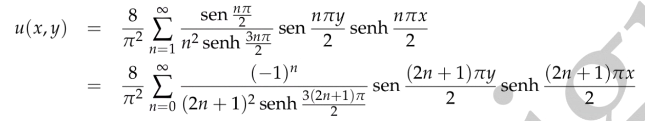

In [37]:
def u(x, t, n=10):
    """Solução analítica da equação de laplace

    Parameters
    ----------
    x : torch.Tensor
        _description_
    t : torch.Tensor
        _description_

    Returns
    -------
    torch.Tensor
        _description_
    """
    sol = 0
    for i in range(0,n):
      sol += ((-1)**i /((2*i + 1)**2 *(np.sinh(3*(2*i+1)*np.pi/2))))*np.sin((2*i+1)*np.pi*t/2)*np.sinh((2*i+1)*np.pi*x/2)
    sol = sol*(8/np.pi**2)
    return sol


# Treino

In [38]:
import joblib

In [39]:
### Amostra para entrada:
### L: tamanho da amostra
# np.random.seed(42)
L=100
a = 3
b = 2
x = np.random.uniform(0,a, size=L) ##
t = np.random.uniform(0,b, size=L)

# joblib.dump(x, PATH + 'x.pkl')
# joblib.dump(t, PATH + 't.pkl')

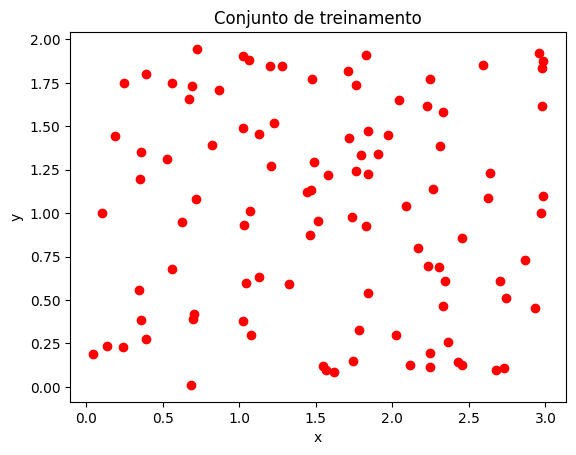

In [40]:
# x = joblib.load(PATH + 'x.pkl')
# t = joblib.load(PATH + 't.pkl')

plt.plot(x, t, 'or')
#plt.plot(dom_pred, im_pred, 'or')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Conjunto de treinamento')
plt.show()

In [41]:
# Convertendo para tensor
x = np.expand_dims(x, axis=0)
t = np.expand_dims(t, axis=0)

inp = torch.tensor(np.concatenate([x, t]).T)

In [ ]:
net = Net(n_input=2,
          n_neurons=10,
          activation_functions=nn.Tanh,
          loss=loss_laplace,
          loss_params={'aceleracao': False},
          optimizer=optim.Adamax,
          optimizer_params={'lr': 0.001})

In [ ]:
nt = net.net()
nt.parameters

<bound method Module.parameters of Model(
  (features): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Tanh()
  )
  (out): Sequential(
    (0): Linear(in_features=10, out_features=1, bias=True)
  )
)>

In [44]:
epochs_array, loss_array = net.fit(x=inp, epochs=10000, nbatches=1, output_loss=True)

Epoch 1000, Loss 11033.885960126623
Epoch 2000, Loss 2295.271743354878


KeyboardInterrupt: 

In [ ]:
nn.Tanh()

In [ ]:
inp.shape

In [ ]:
metricas(net, u, a, b)

In [ ]:
fig1, fig2 = plot_solucao_erro_l2(net, u, a, b)

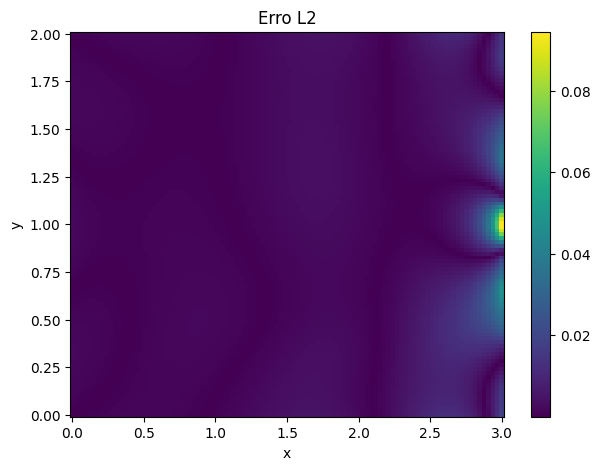

In [ ]:
fig2

# Testes

In [ ]:
from itertools import product
from tqdm.notebook import tqdm
import time
import glob

In [ ]:
params = {
    'n_epochs': [20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000, 20000],
    'n_leyers': [5],
    'n_neuros': [10],
    'activation_function': [nn.SiLU, nn.ReLU, nn.Tanh],
    'aceleracao': [False],
    'optimizer': ["Adamax"],
    'learn_rate': [0.001]
}

In [ ]:
combinacoes_parametros = product(*params.values())

In [ ]:
cols = list(params.keys()) + ['erro_quadrado', 'erro_absoluto', 'tempo', 'id']
df = pd.DataFrame(columns=cols)
today = str(pd.to_datetime("today"))[:10]

In [ ]:
name_file = 'estudo_funcoes_ativacao'
id_ant = 0

In [ ]:
df = pd.DataFrame(columns=cols + ['Loss'])
if len(glob.glob(PATH + f'{name_file}.parquet')) > 0:
  df = pd.read_parquet(PATH + f'{name_file}.parquet')

  id_ant = int(df['id'].iloc[-1].split('_')[1])
  print(id_ant)
  df.tail()

In [ ]:
df.tail()

,n_epochs,n_leyers,n_neuros,activation_function,aceleracao,optimizer,learn_rate,erro_quadrado,erro_absoluto,tempo,id,Loss


In [ ]:
df['erro_quadrado'].min()

nan

In [ ]:
  n_epochs = None
  n_layers = None
  n_neuros = None
  activation_function = None
  aceleracao = None
  optimizer = None
  learn_rate = None

0it [00:00, ?it/s]

Epoch 1000, Loss 1.2933073288516383
Epoch 2000, Loss 0.6825571031321904
Epoch 3000, Loss 0.3485342928184054
Epoch 4000, Loss 0.2822530455760678
Epoch 5000, Loss 0.2540809094633957
Epoch 6000, Loss 0.24162199636438875
Epoch 7000, Loss 0.2233174467354614
Epoch 8000, Loss 0.2218125976849648
Epoch 9000, Loss 0.20385440778504266
Epoch 10000, Loss 0.19621894782309152
Epoch 11000, Loss 0.18980375116247264
Epoch 12000, Loss 0.18424305829783127
Epoch 13000, Loss 0.17929329546646441
Epoch 14000, Loss 0.17488969158432552
Epoch 15000, Loss 0.1712493883251158
Epoch 16000, Loss 0.1673048069323336
Epoch 17000, Loss 0.16370799957719112
Epoch 18000, Loss 0.16067149797246433
Epoch 19000, Loss 0.15791829962846687
Epoch 20000, Loss 0.1553517351201872
Epoch 1000, Loss 27.184417712465606
Epoch 2000, Loss 26.16843564901707
Epoch 3000, Loss 22.225117475969924
Epoch 4000, Loss 21.71134590893033
Epoch 5000, Loss 20.49169858629197
Epoch 6000, Loss 19.451063449701365
Epoch 7000, Loss 18.88717198518105
Epoch 8000,

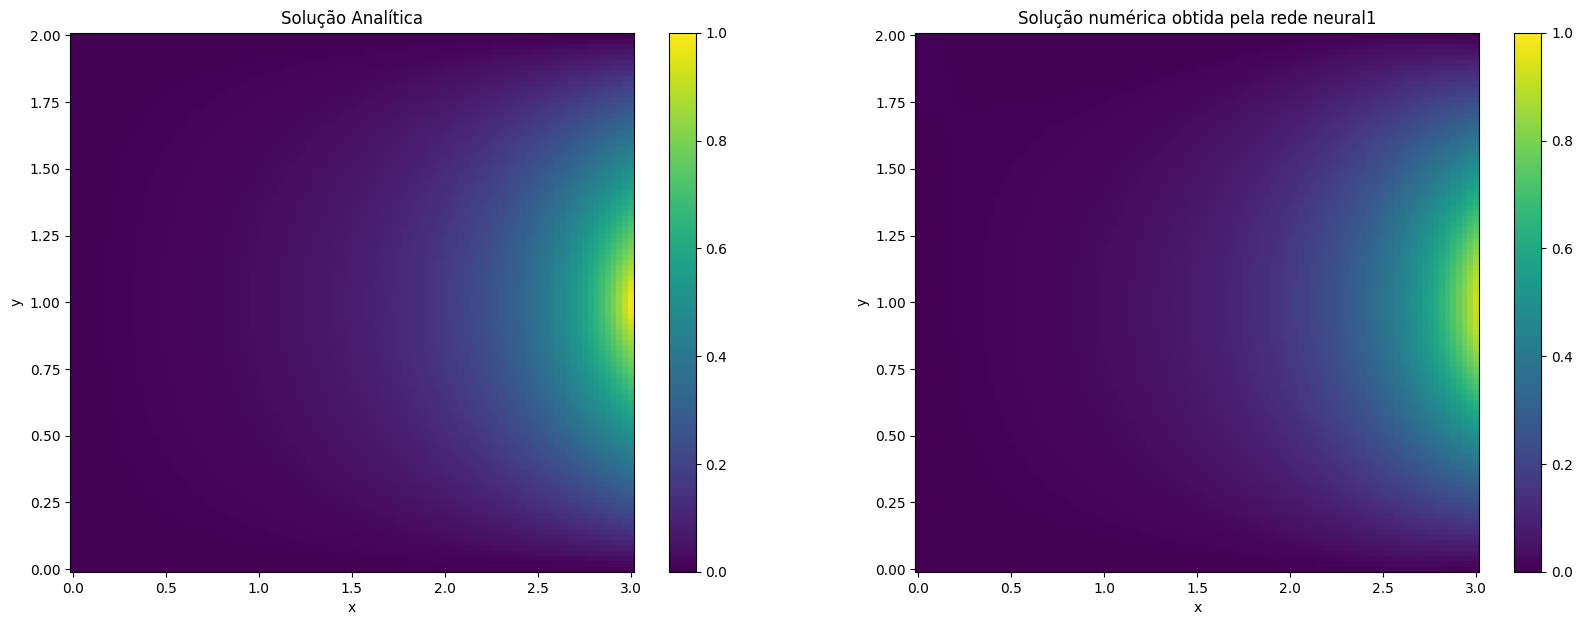

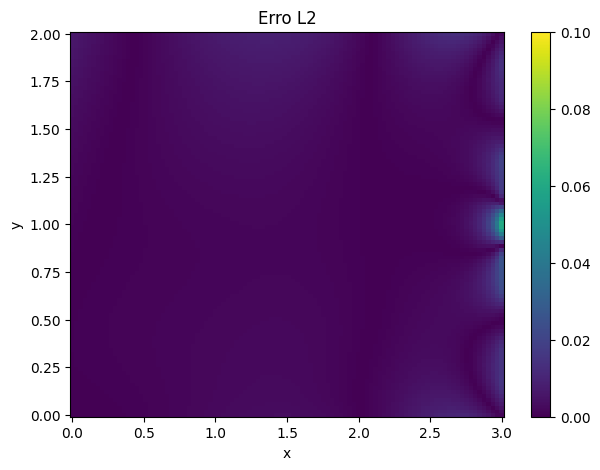

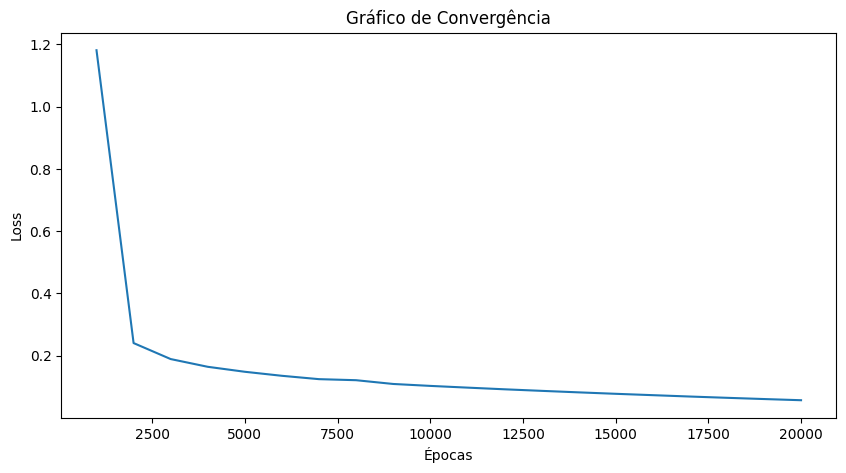

In [ ]:
cont = 1

for i in tqdm(combinacoes_parametros):
  if cont <= id_ant:
    print(cont)
    cont += 1
    continue
  plt.close('all')
  n_epochs = i[0]
  n_layers = i[1]
  n_neuros = i[2]
  activation_function = i[3]
  aceleracao = i[4]
  optimizer = i[5]
  learn_rate = i[6]

  net = Net(layers=[2] + [n_neuros]*n_layers + [1],
          activation_functions=[activation_function]*n_layers,
          loss=loss_laplace,
          loss_params={'aceleracao': aceleracao},
          optimizer=getattr(optim, optimizer),
          optimizer_params={'lr': learn_rate})

  # Obtendo o tempo de inicio
  inicio = time.time()
  # Treino
  epochs_array, loss_array = net.fit(x=inp, epochs=n_epochs, nbatches=1, output_loss=True)
  # Tempo de treinamento
  fim = time.time()
  tempo = fim - inicio

  mean_squared_error, mean_absolute_error = metricas(net, u, a, b)

  fig_solucao, fig_error = plot_solucao_erro_l2(net, u, a, b)

  id = f'teste_{cont}_data_{today}'

  if not os.path.exists(PATH + f'fig/{name_file}'):
    os.makedirs(PATH + f'fig/{name_file}')

  if len(epochs_array) > 0:
    fig_conv = plot_convergencia(epochs_array, loss_array)
    fig_conv.savefig(PATH + f'fig/{name_file}/convergencia_'+id+'.png')

  fig_solucao.savefig(PATH + f'fig/{name_file}/solucao_'+id+'.png')
  fig_error.savefig(PATH + f'fig/{name_file}/error_'+id+'.png')


  df.loc[df.shape[0]] = [n_epochs,
                         n_layers,
                         n_neuros,
                         str(activation_function),
                         aceleracao,
                         optimizer,
                         learn_rate,
                         mean_squared_error.numpy().tolist(),
                         mean_absolute_error.numpy().tolist(),
                         tempo,
                         id,
                         sum(loss_array[-1])]
  df.to_parquet(PATH + f'{name_file}.parquet', index=False)
  cont += 1
  del net

In [ ]:
df

,n_epochs,n_leyers,n_neuros,activation_function,aceleracao,optimizer,learn_rate,erro_quadrado,erro_absoluto,tempo,id,Loss
0,20000,5,10,<class 'torch.nn.modules.activation.SiLU'>,False,Adamax,0.001,0.000052,0.003509,206.218807,teste_1_data_2023-06-25,0.155352
1,20000,5,10,<class 'torch.nn.modules.activation.ReLU'>,False,Adamax,0.001,0.009656,0.068275,198.583156,teste_2_data_2023-06-25,14.255355
2,20000,5,10,<class 'torch.nn.modules.activation.Tanh'>,False,Adamax,0.001,0.000012,0.001898,204.682025,teste_3_data_2023-06-25,0.057890
3,20000,5,10,<class 'torch.nn.modules.activation.SiLU'>,False,Adamax,0.001,0.000006,0.001107,207.018963,teste_4_data_2023-06-25,0.034607
4,20000,5,10,<class 'torch.nn.modules.activation.ReLU'>,False,Adamax,0.001,0.013244,0.073451,198.266945,teste_5_data_2023-06-25,19.933748
5,20000,5,10,<class 'torch.nn.modules.activation.Tanh'>,False,Adamax,0.001,0.000015,0.002709,205.118646,teste_6_data_2023-06-25,0.055617
6,20000,5,10,<class 'torch.nn.modules.activation.SiLU'>,False,Adamax,0.001,0.000015,0.001618,209.186785,teste_7_data_2023-06-25,0.081087
7,20000,5,10,<class 'torch.nn.modules.activation.ReLU'>,False,Adamax,0.001,0.018181,0.108882,200.070296,teste_8_data_2023-06-25,44.324551
8,20000,5,10,<class 'torch.nn.modules.activation.Tanh'>,False,Adamax,0.001,0.000012,0.001892,207.413833,teste_9_data_2023-06-25,0.060749
9,20000,5,10,<class 'torch.nn.modules.activation.SiLU'>,False,Adamax,0.001,0.000007,0.001208,210.598271,teste_10_data_2023-06-25,0.040558


In [ ]:
str(Cos)

In [ ]:
[2] + [n_neuros]*n_layers + [1]

In [ ]:
[activation_function]*n_layers

In [ ]:
net = Net(layers=[2, 1500, 1],
          activation_functions=[Cos_sin],
          loss=loss_laplace,
          loss_params={},
          optimizer=optim.Adamax,
          optimizer_params={'lr': 0.001})

In [ ]:
nn.PReLU

# Otimização

In [ ]:
def objective(trial):
  # Sugere um valor entre 1 e 10
  n_layers = trial.suggest_int('n_layers', 1, 5)
  activation_function = trial.suggest_categorical("activation_function", ['Cos_sin', 'Cos', 'Sin', 'Tanh', 'ReLU', 'SiLU', 'PReLU', 'LeakyReLU'])
  optimizer = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD", "Adamax"])
  lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)

  epochs = trial.suggest_int('epochs', 1000, 30000)
  nbatches = trial.suggest_int('nbatches', 1, 10)

  n_neurons = trial.suggest_int(f'n_neurons', 1, 50)
  aceleracao = trial.suggest_categorical("aceleracao", [True, False])

  layers = [2] + [n_neurons]*n_layers + [1] # Input layer
  activation_function_list = []
  if 'Cos_sin' == activation_function:
    activation_function_list = [Cos_sin]*n_layers
  elif 'Cos' == activation_function:
    activation_function_list = [Cos]*n_layers
  elif 'Sin' == activation_function:
    activation_function_list = [Sin]*n_layers
  else:
    activation_function_list = [getattr(nn, activation_function)]*n_layers


  # activation_function_list = [activation_function]*n_layers
  print('n_neuros ', n_neurons)
  print('layers ', n_layers)
  print('epochs ', epochs)

  net = Net(layers=layers,
            activation_functions=activation_function_list,
            loss=loss_laplace,
            loss_params={'aceleracao': aceleracao},
            optimizer=getattr(optim, optimizer),
            optimizer_params={'lr': lr})

  epochs_array, loss_array = net.fit(x=inp, epochs=epochs, nbatches=nbatches, output_loss=True)

  mean_squared_error, mean_absolute_error = metricas(net, u, a, b)

  return mean_squared_error

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
fig = optuna.visualization.plot_contour(study, params=["n_layers", "optimizer"])
fig.show()

In [ ]:
fig = optuna.visualization.plot_param_importances(study)
fig.show()